In [1]:
%pip install -r '../requirements.txt'

Note: you may need to restart the kernel to use updated packages.


In [2]:
import shutil
import os
import zipfile


dependency_path = '../dependencies/'
file_name = 'archive.zip'
file_id = '1PWh1rMqWh0JjkygP-CZbYn-VtL2TMrmB'
files_to_check = ['reviews_0-250.csv', 'reviews_250-500.csv', 'reviews_500-750.csv', 'reviews_750-1250.csv', 'reviews_1250-end.csv']


def download_file(id_of_file, destination):
    os.system('gdown ' + id_of_file + ' -O ' + destination)

def check_files():
    if not os.path.exists(dependency_path):
        return False
    for file_to_check in files_to_check:
        if not os.path.exists(os.path.join(dependency_path, file_to_check)):
            return False
    return True

if not check_files():
    if os.path.exists(dependency_path):
        shutil.rmtree(dependency_path)
    os.makedirs(dependency_path) 
    download_file(file_id, dependency_path + file_name)
    try:
        with zipfile.ZipFile(dependency_path + file_name, 'r') as zip_ref:
            zip_ref.extractall(dependency_path)
        print("Extraction successful.")
        os.remove(dependency_path + file_name)
    except zipfile.BadZipFile:
        print("Error while extracting zip")
    if os.path.exists(dependency_path + '__MACOSX'):
        shutil.rmtree(dependency_path + '__MACOSX')
    for file in files_to_check:
        shutil.move(dependency_path + 'archive/' + file, dependency_path + file)
    shutil.rmtree(dependency_path + 'archive')
else:
    print("Files already exist, skipping download")
    

Files already exist, skipping download


In [3]:
import requests
from bs4 import BeautifulSoup

if not os.path.exists('../data/brand_links.txt'):
    brand_lst_link = 'https://sephora.com/brands-list'
    response = requests.get(url=brand_lst_link, headers={'User-Agent': 'Your Custom User-Agent'})
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Scraping brand links and saving them into a list
    brand_link_lst = []
    main_box = soup.find_all(attrs={"data-at": "brand_link", "data-comp": "StyledComponent BaseComponent "})
    
    for brand in main_box:
        brand_link = brand.get('href')
        if not str(brand_link).startswith('/brand'):
            brand_link = '/brand' + brand_link
        brand_link_lst.append("https://www.sephora.com" + brand_link + "/all?pageSize=300")
    
    if not os.path.exists('../data/'):
        os.mkdir('../data/')
    with open('../data/brand_links.txt', 'w') as f:
        for link in brand_link_lst:
            f.write(link + '\n')
            
    print("Saving brand links to /data/brand_links.txt")
    
else:
    print("Extracted brand links found at /data/brand_links.txt, proceeding with locally saved file. To re-extract the brand links, delete the file and run the cell again")


Extracted brand links found at /data/brand_links.txt, proceeding with locally saved file. To re-extract the brand links, delete the file and run the cell again


In [4]:
import json
import pandas as pd


brand_links = []
with open('../data/brand_links.txt', 'r') as f:
    for line in f:
        brand_links.append(line.strip())

if not os.path.exists('../data/product_links.csv'):
    print("Brand links have been loaded from the text file: brand_links.txt")
    
    brand_names = []
    product_names = []
    product_ids = []
    product_links = []
    
    for brand in brand_links:
        brand_name = brand.split("/")[4]
        print("Scraping data for " + brand_name)
        response = requests.get(url=brand, headers={'User-Agent': 'Your Custom User-Agent'})
        soup = BeautifulSoup(response.content, 'html.parser')
        try:
            products = soup.find(attrs={"data-comp": "PageJSON "})
            products = json.loads(products.get_text('script')).get('page').get('nthBrand').get('products')
            for product in products:
                mini_url = product.get('targetUrl')
                product_name = product.get('displayName')
                product_id = product.get('productId')
                product_link = "https://www.sephora.com" + mini_url + "/all?pageSize=300"
    
                brand_names.append(brand_name)
                product_names.append(product_name)
                product_ids.append(product_id)
                product_links.append(product_link)
        except TypeError as e:
            print("No products found for the Brand: " + brand_name)
    
    products_df = pd.DataFrame({
        'brand_name': brand_names,
        'product_name': product_names,
        'product_id': product_ids,
        'product_link': product_links
    })
    products_df.to_csv("../data/product_links.csv")
    print("Saving product links to /data/product_links.csv")
    
else:
    products_df = pd.read_csv('../data/product_links.csv')
    brand_names = products_df['brand_name'].tolist()
    product_names = products_df['product_name'].tolist()
    product_ids = products_df['product_id'].tolist()
    product_links = products_df['product_link'].tolist()
    print("Extracted product links found at /data/product_links.csv, proceeding with locally saved file. To re-extract the product links, delete the file and run the cell again")


Extracted product links found at /data/product_links.csv, proceeding with locally saved file. To re-extract the product links, delete the file and run the cell again


In [5]:
reviews = []
for file in files_to_check:
    reviews.append(pd.read_csv(dependency_path + file, low_memory=False))
reviews_df = pd.concat(reviews, ignore_index=True)

In [6]:
reviews_df.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [7]:
reviews_df.describe()

,Unnamed: 0,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,price_usd
count,1.094411e+06,1.094411e+06,926423.000000,532819.000000,1.094411e+06,1.094411e+06,1.094411e+06,1.094411e+06
mean,1.989864e+05,4.299158e+00,0.839962,0.767782,4.177126e+00,8.948695e-01,3.282257e+00,4.900838e+01
std,1.749886e+05,1.149444e+00,0.366642,0.317164,2.271524e+01,5.288943e+00,1.967482e+01,4.004338e+01
min,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,5.590600e+04,4.000000e+00,1.000000,0.652174,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01
50%,1.308240e+05,5.000000e+00,1.000000,0.928571,0.000000e+00,0.000000e+00,0.000000e+00,3.900000e+01
75%,3.285265e+05,5.000000e+00,1.000000,1.000000,3.000000e+00,1.000000e+00,3.000000e+00,6.200000e+01
max,6.021290e+05,5.000000e+00,1.000000,1.000000,5.464000e+03,1.159000e+03,5.050000e+03,1.900000e+03


In [8]:
product_id_list = reviews_df['product_id'].unique()

In [9]:
len(product_id_list)

2351

In [10]:
common_products = []
for product in product_ids:
    for product_idx in product_id_list:
        if product == product_idx:
            common_products.append(product)
print("There are " +str(len(common_products)) + " common products")

There are 1593 common products


In [11]:
reviews_df = reviews_df[reviews_df['product_id'].isin(common_products)]

In [12]:
len(reviews_df['product_id'].unique())

1593

In [13]:
products_df = products_df[products_df['product_id'].isin(common_products)]

In [14]:
products_df.count()

Unnamed: 0      1593
brand_name      1593
product_name    1593
product_id      1593
product_link    1593
dtype: int64

In [15]:
import time
import json


def remove_text_in_parentheses(input_string):
    result = re.sub(r'\([^)]*\)', '', input_string)
    return result.strip()

def get_chemicals_from_link(product_link):
    response = requests.get(url=product_link, headers={'User-Agent': 'User-Agent'})
    soup = BeautifulSoup(response.content, 'html.parser')
    product = soup.find(attrs={"data-comp": "PageJSON "})
    try:
        ingredients_text = json.loads(product.get_text('script')).get('page').get('product').get('currentSku').get(
            'ingredientDesc')
    except Exception as e:
        return []
    if not ingredients_text:
        return []
    ingredients_soup = BeautifulSoup(ingredients_text, 'html.parser')
    names = ingredients_soup.get_text().split(',')
    individual_names = [name for name in names if name.strip()]

    cleaned_names = []
    for name in individual_names:
        if name.startswith('*'):
            continue
        if len(name) < 4:
            continue
        cleaned_name = remove_text_in_parentheses(name)
        if cleaned_name and not cleaned_name.endswith('*'):
            cleaned_names.append(cleaned_name)
            
    ingredients = list(set(cleaned_names))
    chemicals = []

    for ingredient in ingredients:
        retries = 2  # Number of retries
        while retries > 0:
            response = requests.get("https://webbook.nist.gov/cgi/cbook.cgi?Name=" + ingredient + "&Units=SI")
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                title = soup.find('title').get_text()
                if title == "Search Results":
                    best_match = soup.find('main').find('ol').find('li').find('a').get_text()
                    chemicals.append(best_match)
                elif title == "Name Not Found":
                    break
                elif title == "No Matching Species Found":
                    break
                else:
                    chemicals.append(title)
                break 
            else:
                time.sleep(5)
                retries -= 1
        else:
            print(f"Error: Unable to fetch data for ingredient {ingredient}")
    
    return chemicals


if not os.path.exists('../data/products.csv'):
    print("Product links has been loaded from the file: product_links.csv")
    chemicals_lists = []
    total_products = len(products_df)
    
    for i, (index, row) in enumerate(products_df.iterrows(), start=1):
        product_link = row['product_link']
        product_name = row['product_name']
        chemicals = get_chemicals_from_link(product_link)
        chemicals_lists.append(chemicals)
        if chemicals:
            print(f"Chemicals extracted for {i}/{total_products} products: {product_name}")   
            print(chemicals)
        else:
            print("No chemicals found for " + product_name)
    
    products_df['chemicals_list'] = chemicals_lists
    products_df.to_csv("../data/products.csv")
    print("Saving chemicals in products to /data/products.csv")
else:
    products_df = pd.read_csv("../data/products.csv")
    print("Extracted chemicals in products found at /data/products.csv, proceeding with locally saved file. To re-extract the product links, delete the file and run the cell again")

Extracted chemicals in products found at /data/products.csv, proceeding with locally saved file. To re-extract the product links, delete the file and run the cell again


In [16]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      1498 non-null   int64 
 1   brand_name      1498 non-null   object
 2   product_name    1498 non-null   object
 3   product_id      1498 non-null   object
 4   product_link    1498 non-null   object
 5   chemicals_list  1498 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.3+ KB


In [17]:
products_df = products_df[["brand_name", "product_name", "product_id", "product_link", "chemicals_list"]]

In [18]:
products_df.count()

brand_name        1498
product_name      1498
product_id        1498
product_link      1498
chemicals_list    1498
dtype: int64

In [19]:
products_df = products_df[products_df['chemicals_list'].apply(lambda x: len(eval(x)) > 0)]

In [20]:
products_df.count()

brand_name        1498
product_name      1498
product_id        1498
product_link      1498
chemicals_list    1498
dtype: int64

In [21]:
from collections import Counter
import ast


common_chemicals_list = []

for chemicals_list in products_df['chemicals_list']:
    common_chemicals_list.extend(ast.literal_eval(chemicals_list))

chemicals_frequency = dict(Counter(common_chemicals_list).most_common())

print("Total unique chemicals:", len(chemicals_frequency.keys()))

high_frequency_chemicals_list = []
for chemical in chemicals_frequency.keys():
    if chemicals_frequency[chemical] > 15:
        high_frequency_chemicals_list.append(chemical)


Total unique chemicals: 406


In [22]:
import re


def get_iupac_name(chemical_name):
    try:
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{chemical_name}/json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            iupac_name = data['PC_Compounds'][0]['props'][10]['value']['sval']
            return iupac_name
        else:
            return None
    except Exception as ex:
        print(f"Error: {str(ex)}")
        return None


def identify_functional_groups(chemical_name):
    if not chemical_name:
        return "Other"
    iupac_name = get_iupac_name(chemical_name)
    if not iupac_name:
        return "Other"
    alcohols = re.compile(r"^(.*)ol$")
    aldehydes = re.compile(r"^(.*)al$")
    ketones = re.compile(r"^(.*)one$")
    carboxylic_acids = re.compile(r"^(.*)oic acid$")
    amines = re.compile(r"^(.*)amine$")
    amides = re.compile(r"^(.*)amide$")
    esters = re.compile(r"(.*) (.*)ate$")
    
    if alcohols.match(iupac_name):
        return "Alcohol"
    elif aldehydes.match(iupac_name):
        return "Aldehyde"
    elif ketones.match(iupac_name):
        return "Ketone"
    elif carboxylic_acids.match(iupac_name):
        return "Carboxylic Acid"
    elif amines.match(iupac_name):
        return "Amine"
    elif amides.match(iupac_name):
        return "Amide"
    elif esters.match(iupac_name):
        return "Ester"
    else:
        return "Other"


In [23]:
print("Chemicals that occur in more than 15 products: ")
for high_frequency_chemical in high_frequency_chemicals_list:
    print(high_frequency_chemical)
print("Total High Frequency chemicals: ", len(high_frequency_chemicals_list))

Chemicals that occur in more than 15 products: 
Glycerin
Propylene Glycol
1,3-Butanediol
Ethanol, 2-phenoxy-
Vitamin E
Citric acid
Sodium hydroxide
sodium benzoate
α-Tocopheryl acetate
1,5-Pentanediol
Squalane
Siloxanes and Silicones, di-Me
Limonene
Linalool
Niacinamide
Lecithin
Dioxosilane
Lactic acid
sodium chloride
Citronellol
1-Hexadecanol
Caffeine
2,6-Octadien-1-ol, 3,7-dimethyl-, (E)-
Betaine
Octadecanoic acid
Chlorphenesin carbamate
Allantoin
Ethanol
Water
9-α-d-Arabinofuranosyladenine
Trehalose
Hexylene glycol
Benzyl alcohol
2,6-Octadienal, 3,7-dimethyl-
Mica
Behenic alcohol
Titanium dioxide (anatase)
Salicylic acid
α-Bisabolol
Butylated Hydroxytoluene
Arginine
Acetic acid, hydroxy-
Vitamin C
9,12-Octadecadienoic acid (Z,Z)-
Potassium hydroxide
2-Propanol, 1,1'-oxybis-
Sorbitol
n-Hexadecanoic acid
Sodium hydrogen sulfite
D-Gluconic acid, δ-lactone
Tromethamine
Cholesterol
Sucrose
Urea
1-Octadecanol
Glucose
Phenylethyl Alcohol
Retinol
Kaolin
1-Dodecanol, 2-octyl-
Dehydroacetic A

In [24]:
products_df.head()

,brand_name,product_name,product_id,product_link,chemicals_list
0,algenist,GENIUS Ultimate Anti-Aging Melting Cleanser,P388200,https://www.sephora.com/product/genius-ultimat...,"['Benzyl Benzoate', 'α-Tocopheryl acetate', 'W..."
1,algenist,GENIUS Liquid Collagen® Serum,P421277,https://www.sephora.com/product/genius-liquid-...,"['1,5-Pentanediol', '9-α-d-Arabinofuranosylade..."
2,algenist,GENIUS Sleeping Collagen Moisturizer,P439055,https://www.sephora.com/product/genius-sleepin...,"['Citric acid', 'Phenylethyl Alcohol', 'α-Iono..."
3,algenist,GENIUS Liquid Collagen Lip Treatment,P432045,https://www.sephora.com/product/genius-liquid-...,"['1,5-Pentanediol', '9-α-d-Arabinofuranosylade..."
4,algenist,GENIUS Ultimate Anti-Aging Eye Cream,P388262,https://www.sephora.com/product/genius-ultimat...,"['Octadecanoic acid', 'Citric acid', '1,5-Pent..."


In [25]:
from ast import literal_eval

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import ssl
import tqdm


if not os.path.exists("../data/fit_model.csv"):
    
    functional_group_chemical = {}
    for chemical in high_frequency_chemicals_list:
        functional_group_chemical[chemical] = identify_functional_groups(chemical)
        
    def get_functional_group_chemical(chemical):
        return functional_group_chemical.get(chemical, Exception("Weird Error!, extra chemical: ", chemical))

    products_df['chemicals_list'] = products_df['chemicals_list'].apply(literal_eval)
    
    chemical_counts = pd.Series([chemical for sublist in products_df['chemicals_list'] for chemical in sublist]).value_counts()
    
    frequent_chemicals = chemical_counts[chemical_counts > 15].index.tolist()
    filtered_chemicals_list = products_df['chemicals_list'].apply(lambda x: [chemical for chemical in x if chemical in frequent_chemicals]).tolist()
    
    
    products_df['filtered_chemicals'] = filtered_chemicals_list
    products_df['functional_groups'] = products_df['filtered_chemicals'].apply(lambda x: [get_functional_group_chemical(chemical) for chemical in x])
    
    print(products_df['functional_groups'])
    
    filtered_products_df = products_df[["brand_name", "product_name", "product_id", "filtered_chemicals", "functional_groups"]]
    
    
    
    unique_functional_groups = set(chem for sublist in filtered_products_df['functional_groups'] for chem in sublist)
    
    for group in unique_functional_groups:
        filtered_products_df[group] = 0
    
    for index, row in filtered_products_df.iterrows():
        groups = row['functional_groups']
        for group in groups:
            filtered_products_df.at[index, group] = 1
    
    encoded_df = filtered_products_df.drop(columns=["brand_name", "product_name", "filtered_chemicals", "functional_groups"], axis=1)
    
    
    products_with_chemicals = encoded_df["product_id"].tolist()
    
    reviews_df = reviews_df[reviews_df['product_id'].isin(products_with_chemicals)]
    
    print("Total unique products in reviews after dropping non common products", len(reviews_df['product_id'].unique()))
    
    reviews_df['review_title'] = reviews_df['review_title'].fillna('').astype(str)
    reviews_df['review_text'] = reviews_df['review_text'].fillna('').astype(str)
    
    sentiment_df = pd.DataFrame()
    sentiment_df['full_review'] = reviews_df['review_title'] + ": " + reviews_df['review_text']
    sentiment_df['product_id'] = reviews_df['product_id']
    
    
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context
    
    nltk.download('vader_lexicon')
    
    sia = SentimentIntensityAnalyzer()
    
    def get_sentiment(text, pbar):
        pbar.update(1)
        return sia.polarity_scores(text)['compound']
    
    total_rows = len(sentiment_df)
    
    with tqdm.tqdm(total=total_rows) as pbar:
        sentiment_df['sentiment_score'] = sentiment_df['full_review'].apply(lambda x: get_sentiment(x, pbar))
        
    
    sentiment_df = sentiment_df.groupby('product_id')['sentiment_score'].mean().reset_index()  
    encoded_df = encoded_df.merge(sentiment_df, on='product_id', how='left')
    encoded_df.to_csv("../data/fit_model.csv")
    
else:
    print("Encoded DF already exists at data/fit_model.csv, so skipping this step")
    encoded_df = pd.read_csv("../data/fit_model.csv")


Encoded DF already exists at data/fit_model.csv, so skipping this step


In [26]:
encoded_df.head()

,product_id,Other,Aldehyde,Amide,Ketone,Ester,Alcohol,Carboxylic Acid,sentiment_score
0,P502978,1,0,1,1,0,1,0,-0.337167
1,P500464,1,1,1,1,0,0,1,-0.312450
2,P483089,1,0,1,0,0,0,0,0.044500
3,P483141,1,0,1,0,1,1,1,0.054383
4,P482747,1,0,0,0,0,1,0,0.072900


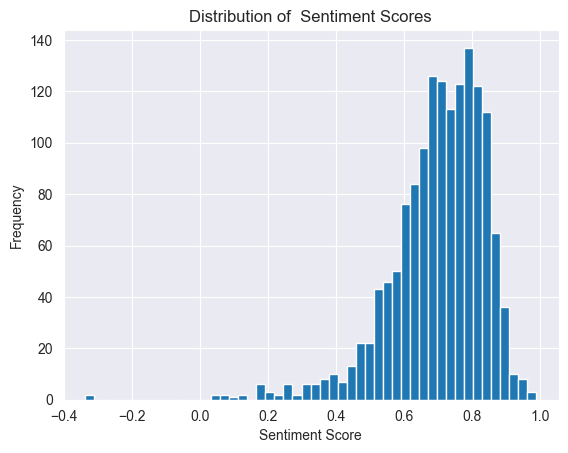

In [27]:
import matplotlib.pyplot as plt


encoded_df['sentiment_score'].hist(bins=50)
plt.title('Distribution of  Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [28]:
X = encoded_df.drop(['product_id','sentiment_score'], axis=1)
y = encoded_df['sentiment_score']

In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error

y_25th_percentile = np.percentile(y, 25)
y_pred_baseline = np.full_like(y, y_25th_percentile)
mse_baseline = mean_squared_error(y, y_pred_baseline)
print(f'Baseline Model MSE: {mse_baseline}')


Baseline Model MSE: 0.02497853628623782


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

models = {}
y_pred_linear = LinearRegression().fit(X_train, y_train).predict(X_test)
y_pred_rf = RandomForestRegressor(max_depth=5, max_leaf_nodes=10).fit(X_train, y_train).predict(X_test)
y_pred_ridge = Ridge(alpha=1.0).fit(X_train, y_train).predict(X_test)

models["linear"] = y_pred_linear
models["Random Forest"] = y_pred_rf
models["Ridge"] = y_pred_ridge

for model in models.keys():
    print(model, "MSE: ",mean_squared_error(y_test, models[model]))

linear MSE:  0.014806961794059059
Random Forest MSE:  0.014758660897018732
Ridge MSE:  0.014810107107279421


/var/folders/cs/rh0jmwf17rj23jjxx0b7rn5m0000gn/T/ipykernel_5688/1169454502.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_feature_importances, y=sorted_feature_names, palette='viridis')


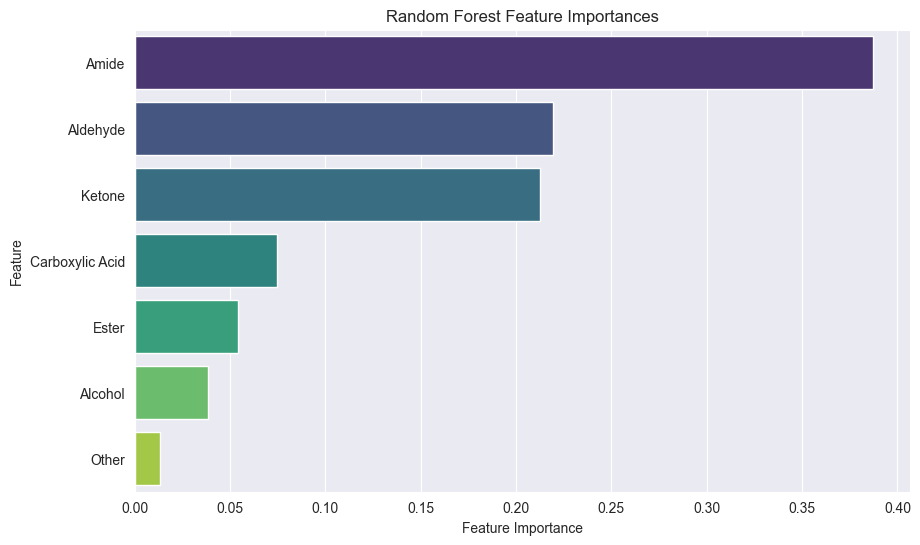

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


rf_model = RandomForestRegressor(max_depth=5, max_leaf_nodes=10, random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = rf_model.feature_importances_

feature_names = X.columns

sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]


plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()


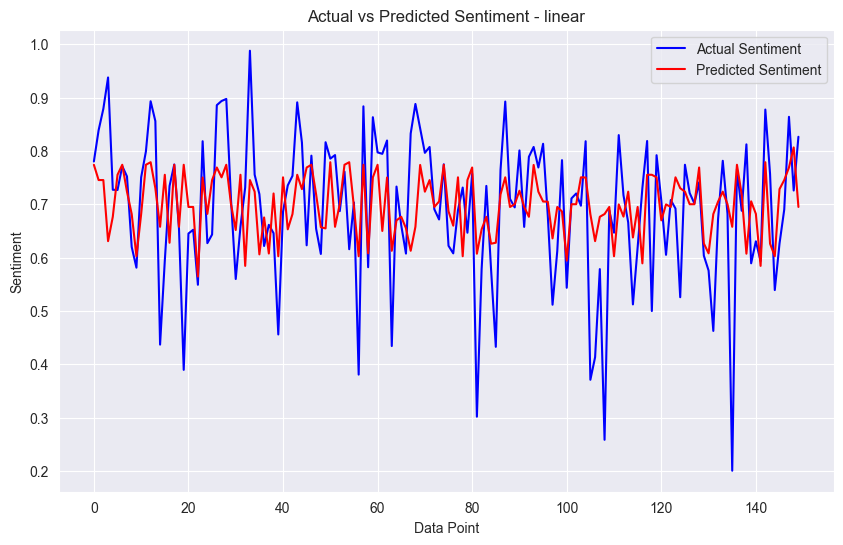

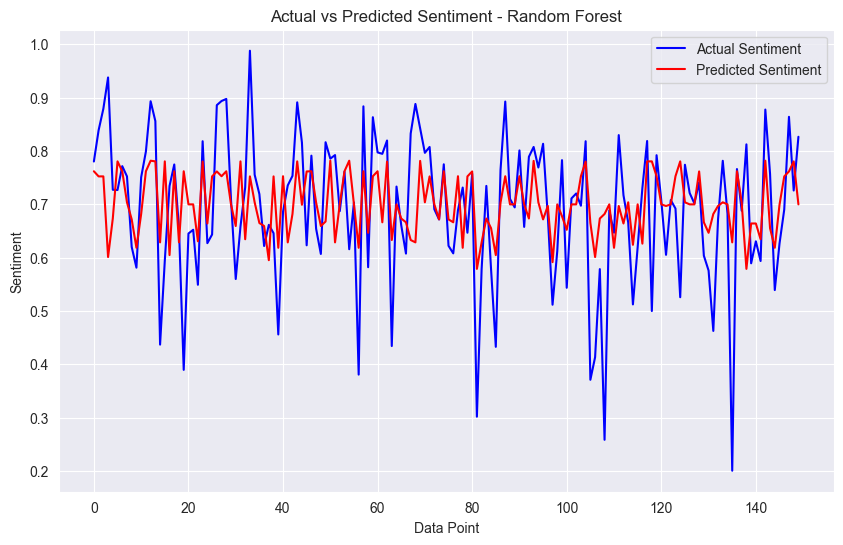

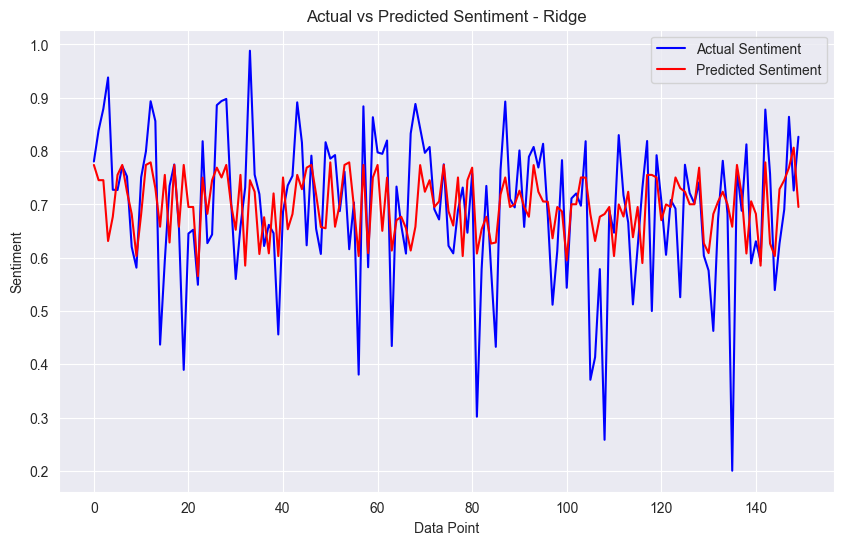

In [133]:
import matplotlib.pyplot as plt


for model_name, y_pred in models.items():
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual Sentiment', color='blue')
    plt.plot(y_pred, label='Predicted Sentiment', color='red')
    plt.xlabel('Data Point')
    plt.ylabel('Sentiment')
    plt.title(f'Actual vs Predicted Sentiment - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [34]:
def map_sentiment_category(sentiment):
    if sentiment <= 0.60:
        return 0
    elif sentiment <= 0.75:
        return 1
    elif sentiment <= 0.8:
        return 2
    else:
        return 3

labels = ['Negative', 'Neutral', 'Positive', 'Very Positive']
encoded_df['sentiment_category'] = encoded_df['sentiment_score'].apply(map_sentiment_category)


In [35]:
X = encoded_df.drop(columns=["sentiment_category", 'product_id', 'sentiment_score'])
y = encoded_df["sentiment_category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train)
dummy_predictions = dummy_classifier.predict(X_test)
dummy_accuracy = dummy_classifier.score(X_test, y_test)
print("Baseline Accuracy:", dummy_accuracy)

Baseline Accuracy: 0.37666666666666665


In [37]:
from sklearn.linear_model import LogisticRegression


logistic_model = LogisticRegression(max_iter=10000)

logistic_model.fit(X_train, y_train)

predictions = logistic_model.predict(X_test)

# Evaluate the model
accuracy = logistic_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.53


In [38]:
from sklearn.tree import DecisionTreeClassifier


dt_classifier = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)

dt_accuracy = dt_classifier.score(X_test, y_test)
print("Decision Tree Classifier Accuracy:", dt_accuracy)

Decision Tree Classifier Accuracy: 0.5133333333333333


Best Random Forest Classifier Accuracy: 0.5466666666666666
Best Depth: 9
Best Leaf Nodes: 20


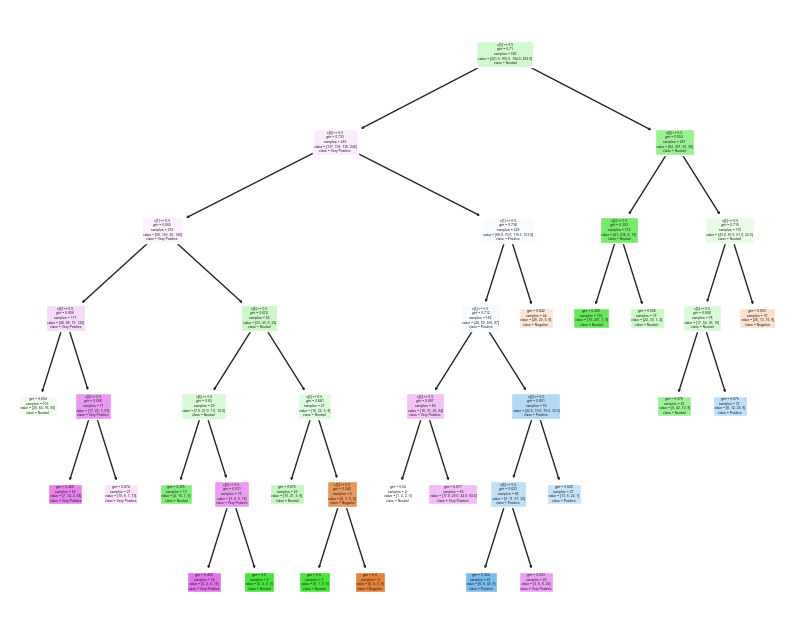

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt


max_depth = 11
max_leaf_nodes = 21
best_accuracy = 0
best_depth = 0
best_leaf_nodes = 0

for depth in range(3, max_depth):
    for leaf_nodes in range(3, max_leaf_nodes):
        rf_classifier = RandomForestClassifier(max_depth=depth, max_leaf_nodes=leaf_nodes)
        rf_classifier.fit(X_train, y_train)
        rf_accuracy = rf_classifier.score(X_test, y_test)
        if rf_accuracy > best_accuracy:
            best_accuracy = rf_accuracy
            best_depth = depth
            best_leaf_nodes = leaf_nodes

print("Best Random Forest Classifier Accuracy:", best_accuracy)
print("Best Depth:", best_depth)
print("Best Leaf Nodes:", best_leaf_nodes)

best_model = RandomForestClassifier(max_depth=best_depth, max_leaf_nodes=best_leaf_nodes)
best_model.fit(X_train, y_train)

tree_to_visualize = best_model.estimators_[0]
plt.figure(figsize=(10, 8))
tree.plot_tree(tree_to_visualize, class_names=labels, filled=True)
plt.show()


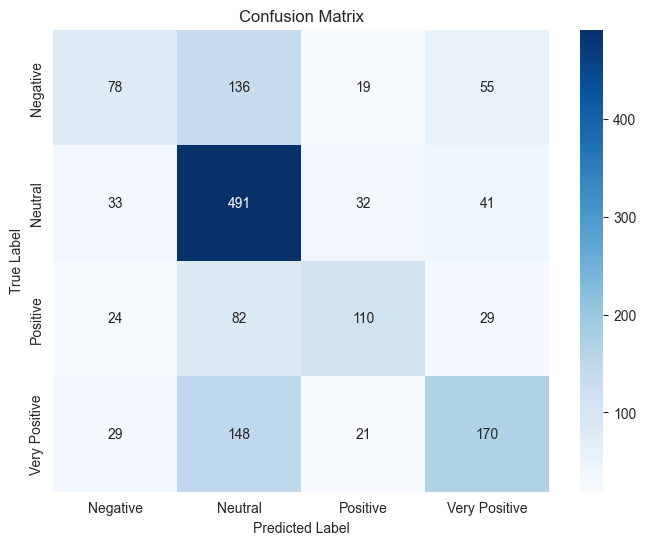

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y, best_model.predict(X))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')


plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(conf_matrix))+0.5, labels=labels)
plt.yticks(ticks=np.arange(len(conf_matrix))+0.5, labels=labels)
plt.title('Confusion Matrix')

plt.show()

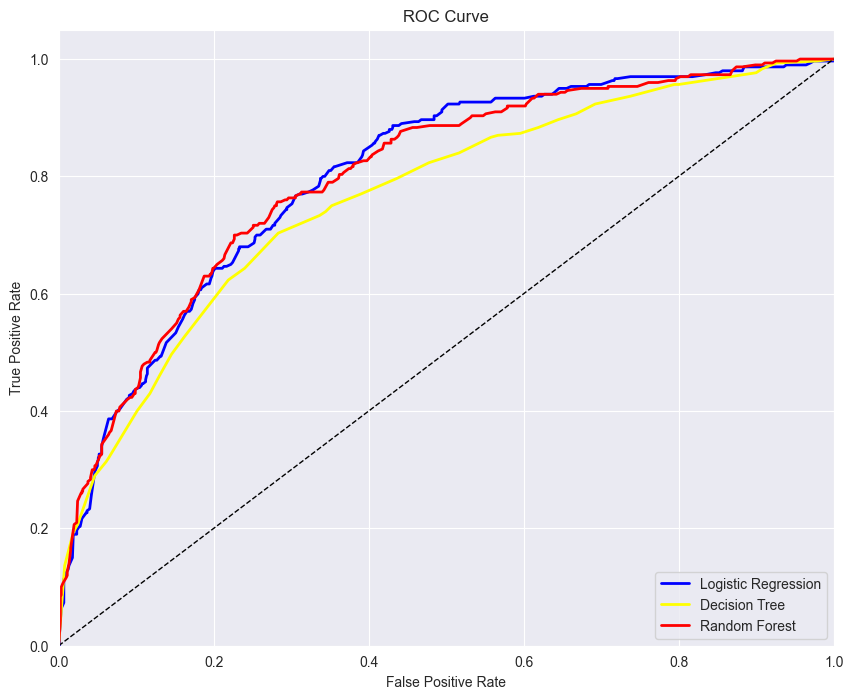

In [41]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt


y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

logistic_probabilities = logistic_model.predict_proba(X_test)
logistic_fpr, logistic_tpr, _ = roc_curve(y_test_binarized.ravel(), logistic_probabilities.ravel())
logistic_auc = auc(logistic_fpr, logistic_tpr)


dt_probabilities = dt_classifier.predict_proba(X_test)
dt_fpr, dt_tpr, _ = roc_curve(y_test_binarized.ravel(), dt_probabilities.ravel())
dt_auc = auc(dt_fpr, dt_tpr)

best_model_probabilities = best_model.predict_proba(X_test)
best_model_fpr, best_model_tpr, _ = roc_curve(y_test_binarized.ravel(), best_model_probabilities.ravel())
best_model_auc = auc(best_model_fpr, best_model_tpr)


dummy_probabilities = dummy_classifier.predict_proba(X_test)
dummy_fpr, dummy_tpr, _ = roc_curve(y_test_binarized.ravel(), dummy_probabilities.ravel())
dummy_auc = auc(dummy_fpr, dummy_tpr)


plt.figure(figsize=(10, 8))
plt.plot(logistic_fpr, logistic_tpr, color='blue', lw=2, label='Logistic Regression')
plt.plot(dt_fpr, dt_tpr, color='yellow', lw=2, label='Decision Tree')
plt.plot(best_model_fpr, best_model_tpr, color='red', lw=2, label='Random Forest')

plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()